<h1 style='font-size: 35px; color: crimson; font-family: Colonna MT; font-weight: 600; text-align: center'>A/B Testing on Marketing Campaigns</h1>

---

<h1 style=' font-weight: 600; font-size: 18px; text-align: left'> Problem Context</h1>

A fashion retail company is preparing to launch new product to their apparel catalog. Nevertheless, the management hasn't decided which one of three marketing campaigns in order to promote their new product. Therefore, they decide to disperse and introduce its new product in random selected outlets to examine which marketing campaigns has the substantial impact on product sales. So the company uses different approach of marketing campaigns for each outlets and new product is evaluated by assessing the weekly sales on this month (4 effective weeks).

<h1 style=' font-weight: 600; font-size: 20px; text-align: left'>1.0. Import Required Libraries</h1>

In [ ]:
# Statistical Analysis and Statistical Modeling
from scipy.stats import shapiro, levene, skew, kurtosis, ttest_ind
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
import statsmodels.api as sm
import scipy.stats as stats

# Data Manipulation and  Visualization
from itertools import combinations
import pandas as pd
import numpy as np
import math
import re


pd.set_option('display.max_columns', 70)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
print("....Libraries Loaded Successfully....")

....Libraries Loaded Successfully....


<h1 style='font-weight: 600; font-size: 18px; text-align: left'>2.0. Import and Preprocessing Dataset</h1>

In [ ]:
filepath = "Datasets/Marketing Campaign Data 01.csv"
df = pd.read_csv(filepath)
display(df)

,OutletID,Market Size,Age of Outlets,Campaigns,Week,Sales ('000')
0,1,Medium,4,Control Group,1,33.73
1,1,Medium,4,Control Group,2,35.67
2,1,Medium,4,Control Group,3,29.03
3,1,Medium,4,Control Group,4,39.25
4,2,Medium,5,Product Discount,1,27.81
...,...,...,...,...,...,...
543,919,Large,2,Loyalty Bonus,4,64.34
544,920,Large,14,Product Discount,1,50.20
545,920,Large,14,Product Discount,2,45.75
546,920,Large,14,Product Discount,3,44.29


<h1 style=' font-weight: 600; font-size: 18px; text-align: left'>3.0. Dataset Informartion Overviews | Exploratory Data Analysis</h1>

Now, let’s move into Exploratory Data Analysis (EDA) — an important step where we take a closer look at our dataset to understand its structure, identify patterns, detect anomalies, and get a sense of the overall distribution of plant parameters. This will help us gain valuable insights and guide the direction of our statistical tests and interpretations.

In [ ]:
df.shape

(548, 6)

In [ ]:
for column in df.columns.tolist(): print(f"{'-'*15} {column}")

--------------- OutletID
--------------- Market Size
--------------- Age of Outlets
--------------- Campaigns
--------------- Week
--------------- Sales ('000')


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   OutletID        548 non-null    int64  
 1   Market Size     548 non-null    object 
 2   Age of Outlets  548 non-null    int64  
 3   Campaigns       548 non-null    object 
 4   Week            548 non-null    int64  
 5   Sales ('000')   548 non-null    float64
dtypes: float64(1), int64(3), object(2)
memory usage: 25.8+ KB


<h4 style='font-size: 15px; font-weight: 600'>3.1.1: Columns Summary</h4>

In [ ]:
def column_summary(df):
    summary_data = []

    for col_name in df.columns:
        col_dtype = df[col_name].dtype
        num_of_nulls = df[col_name].isnull().sum()
        num_of_non_nulls = df[col_name].notnull().sum()
        num_of_distinct_values = df[col_name].nunique()

        if num_of_distinct_values <= 10:
            distinct_values_counts = df[col_name].value_counts().to_dict()
        else:
            top_10_values_counts = df[col_name].value_counts().head(10).to_dict()
            distinct_values_counts = {k: v for k, v in sorted(top_10_values_counts.items(), key=lambda item: item[1], reverse=True)}

        summary_data.append({
            'col_name': col_name,
            'col_dtype': col_dtype,
            'num_of_nulls': num_of_nulls,
            'num_of_non_nulls': num_of_non_nulls,
            'num_of_distinct_values': num_of_distinct_values,
            'distinct_values_counts': distinct_values_counts
        })

    summary_df = pd.DataFrame(summary_data)
    return summary_df


summary_df = column_summary(df)
display(summary_df)

,col_name,col_dtype,num_of_nulls,num_of_non_nulls,num_of_distinct_values,distinct_values_counts
0,OutletID,int64,0,548,137,"{1: 4, 2: 4, 3: 4, 4: 4, 5: 4, 6: 4, 7: 4, 8: ..."
1,Market Size,object,0,548,3,"{'Medium': 320, 'Large': 168, 'Small': 60}"
2,Age of Outlets,int64,0,548,25,"{1: 80, 4: 44, 5: 44, 8: 40, 7: 40, 6: 36, 3: ..."
3,Campaigns,object,0,548,3,"{'Control Group': 188, 'Product Discount': 188..."
4,Week,int64,0,548,4,"{1: 137, 2: 137, 3: 137, 4: 137}"
5,Sales ('000'),float64,0,548,517,"{47.22: 3, 51.09: 3, 48.18: 2, 46.03: 2, 37.32..."


<h4 style='font-size: 15px; font-weight: 600'>3.1.2: Checking Missing Values</h4>

Checking for missing values is a crucial step in data analysis to assess the completeness and reliability of the dataset. This involves identifying any columns with null or empty entries, which may affect the accuracy of statistical models.

In [ ]:
def Missig_values_info(df):
    isna_df = df.isna().sum().reset_index(name='Missing Values Counts')
    isna_df['Proportions (%)'] = isna_df['Missing Values Counts']/len(df)*100
    return isna_df

isna_df = Missig_values_info(df)
isna_df

,index,Missing Values Counts,Proportions (%)
0,OutletID,0,0.00
1,Market Size,0,0.00
2,Age of Outlets,0,0.00
3,Campaigns,0,0.00
4,Week,0,0.00
5,Sales ('000'),0,0.00


In [ ]:

<h4 style='font-size: 15px; font-weight: 600'>3.1.3: Exploring Invalid Entries Dtypes</h4>


Exploring invalid entries in data types involves identifying values that do not match the expected format or category within each column. This includes detecting inconsistencies such as numerical values in categorical fields, incorrect data formats, or unexpected symbols and typos. Invalid entries can lead to errors in analysis and model performance, making it essential to standardize data types and correct anomalies.

In [ ]:
def simplify_dtype(dtype):
    if dtype in (int, float, np.number): return 'Numeric'
    elif np.issubdtype(dtype, np.datetime64): return 'Datetime'
    elif dtype == str: return 'String'
    elif dtype == type(None): return 'Missing'
    else: return 'Other'

def analyze_column_dtypes(df):
    all_dtypes = {'Numeric', 'Datetime', 'String', 'Missing', 'Other'}
    results = pd.DataFrame(index=df.columns, columns=list(all_dtypes), dtype=object).fillna('-')

    for column in df.columns:
        dtypes = df[column].apply(lambda x: simplify_dtype(type(x))).value_counts()
        percentages = (dtypes / len(df)) * 100
        for dtype, percent in percentages.items():
            if percent > 0:
                results.at[column, dtype] = f'{percent:.2f}%'  # Add % sign and format to 2 decimal places
            else:
                results.at[column, dtype] = '-'  # Add dash for 0%
    return results

results = analyze_column_dtypes(df)
display(results)

,String,Numeric,Datetime,Missing,Other
OutletID,-,100.00%,-,-,-
Market Size,100.00%,-,-,-,-
Age of Outlets,-,100.00%,-,-,-
Campaigns,100.00%,-,-,-,-
Week,-,100.00%,-,-,-
Sales ('000'),-,100.00%,-,-,-


<h1 style='font-size: 18px;  font-weight: 600'>4.0: Parametictic Test Assumption Validation</h1>

Before we advance to hypothesis testing it's important to first check whether our variables meet the assumptions required for parametric tests, particularly **normality**. To do this, we’ll use the **Shapiro-Wilk test**, which helps us assess if the distribution of each variable is close to normal. This step ensures the validity of our statistical tests and guides us in choosing the right analysis methods.


<h4 style='font-size: 15px; font-weight: 600'>4.1: Homogeneity of Variance (Homoskedasticity)</h4>

In [ ]:
def Levene_test(df, group_cols, numeric_cols=None):
    if numeric_cols is None:
        numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
        for g in group_cols:
            if g in numeric_cols:
                numeric_cols.remove(g)

    results = []
    for group_col in group_cols:
        for col in numeric_cols:
            grouped_data = [g[col].dropna().values for _, g in df.groupby(group_col)]
            if all(len(g) > 1 for g in grouped_data):  # Ensure each group has enough data
                levene_stat, levene_p = levene(*grouped_data)
                interpretation = '✔' if levene_p > 0.05 else '✖'
                #interpretation = 'Homoscedasticity' if levene_p > 0.05 else 'Heteroscedasticity'

            else:
                levene_stat, levene_p, interpretation = None, None, 'Insufficient data'

            results.append({
                'Group Column': group_col,
                'Variable': col,
                'Test Statistic': levene_stat,
                'P-Value': levene_p,
                'Interpretation': interpretation
            })

    return pd.DataFrame(results)

result_df = Levene_test(df, group_cols=['Campaigns'])
display(result_df)

,Group Column,Variable,Test Statistic,P-Value,Interpretation
0,Campaigns,OutletID,0.79,0.45,✔
1,Campaigns,Age of Outlets,0.07,0.93,✔
2,Campaigns,Week,0.00,1.00,✔
3,Campaigns,Sales ('000'),1.27,0.28,✔


<h4 style='font-size: 15px; font-weight: 600'>4.2: Normality Test | Shapiro-Wilk | Q-Q Plot </h4>

In [ ]:
def bootstrapping(df, column, num_samples=1000, sample_size=30):
    sample_means = []
    for _ in range(num_samples):
        sample = df[column].dropna().sample(n=sample_size, replace=True)
        sample_means.append(sample.mean())
    return sample_means

def shapiro_wilk_test(df, group_col, numeric_cols=None, use_bootstrap=True, num_samples=1000, sample_size=30):
    if numeric_cols is None:
        numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
        if group_col in numeric_cols:
            numeric_cols.remove(group_col)

    results = []
    for group, group_df in df.groupby(group_col):
        for col in numeric_cols:
            if use_bootstrap:
                data = bootstrapping(group_df, col, num_samples=num_samples, sample_size=sample_size)
            else:
                data = group_df[col].dropna()

            if len(data) >= 3:  # Shapiro requires at least 3 values
                stat, p_value = shapiro(data)
                interpretation = 'Normal' if p_value > 0.05 else 'Not Normal'
            else:
                stat, p_value, interpretation = None, None, 'Insufficient data'

            results.append({
                'Main-Group': group_col,
                'Group': group,
                'Variable': col,
                'Test Statistic': stat,
                'P-Value': p_value,
                'Interpretation': interpretation,
                'Used Bootstrap': use_bootstrap
            })

    results_df = pd.DataFrame(results)
    return results_df

result_df = shapiro_wilk_test(df, group_col='Campaigns', use_bootstrap=True)
display(result_df)

,Main-Group,Group,Variable,Test Statistic,P-Value,Interpretation,Used Bootstrap
0,Campaigns,Control Group,OutletID,1.00,0.26,Normal,True
1,Campaigns,Control Group,Age of Outlets,1.00,0.04,Not Normal,True
2,Campaigns,Control Group,Week,1.00,0.02,Not Normal,True
3,Campaigns,Control Group,Sales ('000'),1.00,0.61,Normal,True
4,Campaigns,Loyalty Bonus,OutletID,1.00,0.67,Normal,True
5,Campaigns,Loyalty Bonus,Age of Outlets,1.00,0.01,Not Normal,True
6,Campaigns,Loyalty Bonus,Week,1.00,0.01,Not Normal,True
7,Campaigns,Loyalty Bonus,Sales ('000'),1.00,0.01,Not Normal,True
8,Campaigns,Product Discount,OutletID,1.00,0.58,Normal,True
9,Campaigns,Product Discount,Age of Outlets,0.99,0.00,Not Normal,True


<h4 style='font-size: 15px; font-weight: 600'>4.3: Q-Q plots for Each Group in a Campaigns column</h4>

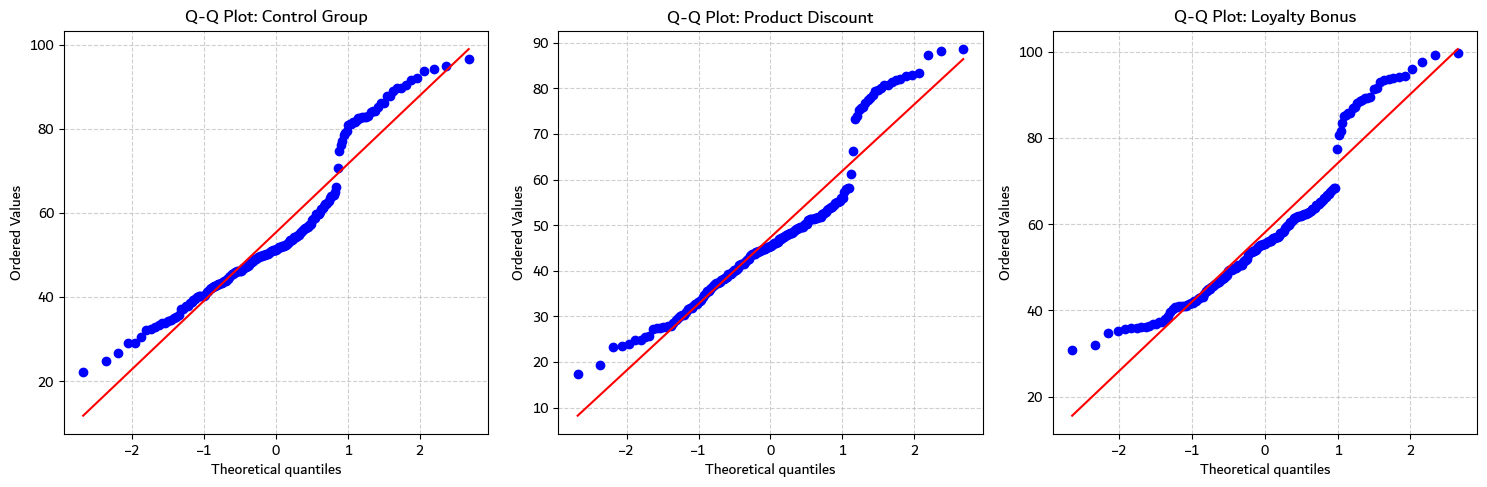

In [ ]:
def qqplot_groups(data, group_col, value_col):
    groups = data[group_col].unique()
    n_groups = len(groups)
    fig, axes = plt.subplots(1, n_groups, figsize=(5 * n_groups, 5))
    if n_groups == 1:
        axes = [axes]

    for ax, group in zip(axes, groups):
        group_data = data[data[group_col] == group][value_col].dropna()
        stats.probplot(group_data, dist="norm", plot=ax)
        ax.set_title(f'Q-Q Plot: {group}')
        ax.grid(linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

qqplot_groups(df, group_col='Campaigns', value_col='Sales (\'000\')')


<h1 style='font-weight: 600; font-size: 20px; text-align: left'>5.0. A/B Testing on Marketing Campaigns | Hypothes Testing (Inferential Statistics)</h1>

<h4 style='font-size: 15px;  font-weight: 600'>5.1: Group-wise Comparatives Analysis of Continuous variables</h4>

In [ ]:
def summary_stats(df, group):
    Metrics = df.select_dtypes(include=np.number).columns.tolist()
    df_without_location = df.drop(columns=[group])
    grand_mean = df_without_location[Metrics].mean()
    sem = df_without_location[Metrics].sem()
    cv = df_without_location[Metrics].std() / df_without_location[Metrics].mean() * 100
    grouped = df.groupby(group)[Metrics].agg(['mean', 'sem']).reset_index()

    summary_df = pd.DataFrame()
    for col in Metrics:
        summary_df[col] = grouped.apply(
            lambda x: f"{x[(col, 'mean')]:.2f} ± {x[(col, 'sem')]:.2f}", axis=1
        )

    summary_df.insert(0, group, grouped[group])
    grand_mean_row = ['Grand Mean'] + grand_mean.tolist()
    sem_row = ['SEM'] + sem.tolist()
    cv_row = ['%CV'] + cv.tolist()

    summary_df.loc[len(summary_df)] = grand_mean_row
    summary_df.loc[len(summary_df)] = sem_row
    summary_df.loc[len(summary_df)] = cv_row

    return summary_df

results = summary_stats(df, group='Campaigns')
results.T

,0,1,2,3,4,5
Campaigns,Control Group,Loyalty Bonus,Product Discount,Grand Mean,SEM,%CV
OutletID,453.81 ± 20.02,488.47 ± 22.83,497.45 ± 21.16,479.66,12.30,60.04
Age of Outlets,9.23 ± 0.49,8.28 ± 0.51,7.98 ± 0.48,8.50,0.28,78.06
Week,2.50 ± 0.08,2.50 ± 0.09,2.50 ± 0.08,2.50,0.05,44.76
Sales ('000'),55.36 ± 1.22,58.10 ± 1.26,47.33 ± 1.10,53.47,0.72,31.34


In [ ]:
results = summary_stats(df, group='Market Size')
results.T

,0,1,2,3,4,5
Market Size,Large,Medium,Small,Grand Mean,SEM,%CV
OutletID,544.36 ± 27.02,493.55 ± 13.86,224.40 ± 12.85,479.66,12.30,60.04
Age of Outlets,7.14 ± 0.47,8.79 ± 0.36,10.80 ± 1.03,8.50,0.28,78.06
Week,2.50 ± 0.09,2.50 ± 0.06,2.50 ± 0.15,2.50,0.05,44.76
Sales ('000'),70.12 ± 1.32,43.99 ± 0.51,57.41 ± 0.86,53.47,0.72,31.34


<h4 style='font-weight: 600; font-size: 15px; text-align: left'>5.2. Independent (Two-Sample) T-Test</h4>

In [ ]:
def Independent_ttest(df, group_cols, Variables):
    results = []
    for category in group_cols:
        unique_groups = df[category].unique()
        group_combinations = list(combinations(unique_groups, 2))

        for column in Variables:
            for group1, group2 in group_combinations:
                group1_data = df[df[category] == group1][column]
                group2_data = df[df[category] == group2][column]
                t_stat, p_value = ttest_ind(group1_data, group2_data, equal_var=False)

                results.append({
                    'Group': category,
                    'Parameter': column,
                    'Group 1': group1,
                    'Group 2': group2,
                    'T-Statistic': t_stat,
                    'P-Value': p_value,
                    'Interpretation': 'Significant' if p_value < 0.05 else 'Not Significant'
                })

    results_df = pd.DataFrame(results)
    return results_df

group_col = ['Campaigns', 'Market Size']
Variables = ['Sales (\'000\')']
Results = Independent_ttest(df, group_cols=group_col, Variables=Variables)
display(Results)

,Group,Parameter,Group 1,Group 2,T-Statistic,P-Value,Interpretation
0,Campaigns,Sales ('000'),Control Group,Product Discount,4.88,0.00,Significant
1,Campaigns,Sales ('000'),Control Group,Loyalty Bonus,-1.56,0.12,Not Significant
2,Campaigns,Sales ('000'),Product Discount,Loyalty Bonus,-6.43,0.00,Significant
3,Market Size,Sales ('000'),Medium,Small,-13.50,0.00,Significant
4,Market Size,Sales ('000'),Medium,Large,-18.54,0.00,Significant
5,Market Size,Sales ('000'),Small,Large,-8.10,0.00,Significant


<h4 style='font-size: 15px; font-weight: 600'>5.3: Analysis of Varience (One Way ANOVA)</h4>

In [ ]:
def rename(text): return re.sub(r'[^a-zA-Z]', "", text)

def One_way_anova(data, Metrics, group_cols):
    results = []
    original_group_cols = group_cols[:]  # Save original names for reporting
    group_cols = [rename(col) for col in group_cols]
    data = data.rename(columns={col: rename(col) for col in data.columns})

    for original_group, group in zip(original_group_cols, group_cols):
        for col in Metrics:
            column_name = rename(col)
            formula = f"{column_name} ~ C({group})"
            model = smf.ols(formula, data=data).fit()
            anova_table = sm.stats.anova_lm(model, typ=2)

            for source, row in anova_table.iterrows():
                p_value = row["PR(>F)"]
                interpretation = "Significant" if p_value < 0.05 else "No significant"
                if source == "Residual":
                    interpretation = "-"

                results.append({
                    "Variable": col,
                    #"Factor": original_group,  # Use original name here
                    "Source": source,
                    "Sum Sq": row["sum_sq"],
                    "df": row["df"],
                    "F-Value": row["F"],
                    "p-Value": p_value,
                    "Interpretation": interpretation
                })

    return pd.DataFrame(results)

group_cols = ['Campaigns', 'Market Size']
Metrics = [ 'Sales (\'000\')']
Anova_results = One_way_anova(df, Metrics, group_cols)
Anova_results

,Variable,Source,Sum Sq,df,F-Value,p-Value,Interpretation
0,Sales ('000'),C(Campaigns),11449.17,2.00,21.95,0.00,Significant
1,Sales ('000'),Residual,142114.11,545.00,NaN,NaN,-
2,Sales ('000'),C(MarketSize),76272.95,2.00,268.91,0.00,Significant
3,Sales ('000'),Residual,77290.33,545.00,NaN,NaN,-


<h4 style='font-size: 15px; font-weight: 600'>5.4: Tukey's Honest Significant Difference (THSD)</h4>

In [ ]:
def Turkey_results(df, Metrics, group=''):
    results_data = []
    for metric in Metrics:
        turkey_results = pairwise_tukeyhsd(endog=df[metric], groups=df[group], alpha=0.05)
        results_table = turkey_results.summary()

        for i in range(1, len(results_table)):
            row = results_table.data[i]
            results_data.append({
                'Metric': metric,
                'Group1': row[0],
                'Group2': row[1],
                'Mean Difference': row[2],
                'P-Value': row[3],
                'Lower CI': row[4],
                'Upper CI': row[5],
                'Reject Null': row[6]
            })

        result_df = pd.DataFrame(results_data)
    return result_df

Metrics = [ 'Sales (\'000\')']
Turkeyresults = Turkey_results(df, Metrics, group='Campaigns')
pd.set_option("display.float_format", "{:.3f}".format)
Turkeyresults

,Metric,Group1,Group2,Mean Difference,P-Value,Lower CI,Upper CI,Reject Null
0,Sales ('000'),Control Group,Loyalty Bonus,2.735,0.244,-1.270,6.739,False
1,Sales ('000'),Control Group,Product Discount,-8.035,0.000,-11.949,-4.121,True
2,Sales ('000'),Loyalty Bonus,Product Discount,-10.770,0.000,-14.774,-6.765,True


<h4 style='font-size: 15px; font-weight: 600'>5.5: Compact Letter Display (CLD)</h4>

In [ ]:
from Scripts.compact_letter_display import compact_letter_table

results = compact_letter_table(df, group="Campaigns", savepath=None)
display(results.T)

,Control Group,Loyalty Bonus,Product Discount,p-value
OutletID,453.81 ± 20.02 a,488.47 ± 22.83 a,497.45 ± 21.16 a,0.3028ns
Age of Outlets,9.23 ± 0.49 a,8.28 ± 0.51 a,7.98 ± 0.48 a,0.1615ns
Week,2.50 ± 0.08 a,2.50 ± 0.09 a,2.50 ± 0.08 a,1.0000ns
Sales ('000'),55.36 ± 1.22 b,58.10 ± 1.26 b,47.33 ± 1.10 a,0.0000***


In [ ]:
from Scripts.compact_letter_display import compact_letter_table

results = compact_letter_table(df, group="Market Size", savepath=None)
display(results.T)

,Large,Medium,Small,p-value
OutletID,544.36 ± 27.02 b,493.55 ± 13.86 b,224.40 ± 12.85 a,0.0000***
Age of Outlets,7.14 ± 0.47 a,8.79 ± 0.36 b,10.80 ± 1.03 b,0.0006***
Week,2.50 ± 0.09 a,2.50 ± 0.06 a,2.50 ± 0.15 a,1.0000ns
Sales ('000'),70.12 ± 1.32 b,43.99 ± 0.51 a,57.41 ± 0.86 c,0.0000***


<h4 style='font-size: 15px; font-weight: 600'>5.6: Compact Letter Display (CLD) Visualization</h4>


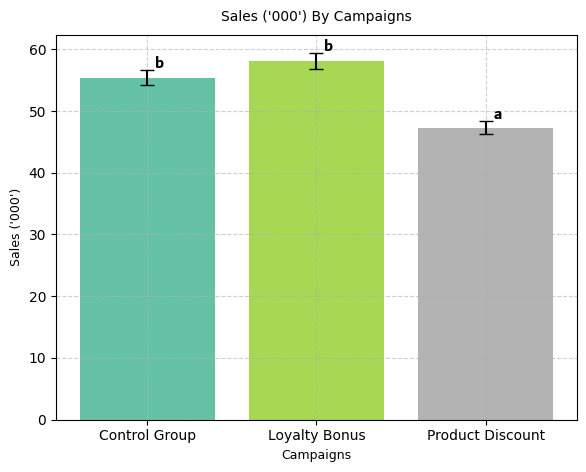

In [ ]:
from Scripts.cld_visualization import cld_plot

Metrics = ['Sales (\'000\')']
cld_plot(df, Metrics, group='Campaigns', savepath=None)

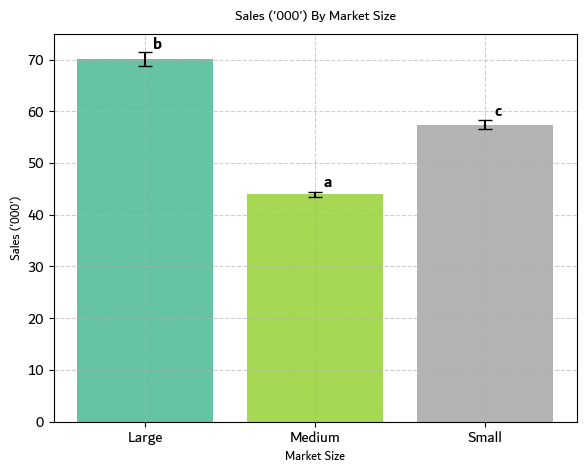

In [ ]:
from Scripts.cld_visualization import cld_plot

Metrics = ['Sales (\'000\')']
cld_plot(df, Metrics, group='Market Size', savepath=None)

<h1 style='font-weight: 600; font-size: 20px; text-align: left'>6.0. Insights and Key Findings </h1>



- The A/B testing analysis was designed to evaluate the impact of three different marketing strategies—Control (no campaign), Loyalty Bonus, and Product Discount—on overall sales performance. The results show a statistically significant difference in sales between the groups (p-value = 0.0000\*\*\*), meaning the choice of marketing strategy has a meaningful impact on revenue outcomes.

- From the observed sales data, the Loyalty Bonus campaign resulted in the highest average sales (58.10K), slightly higher than the Control Group (55.36K), while the Product Discount campaign recorded the lowest sales (47.33K). According to the Compact Letter Display, both the Control and Loyalty Bonus groups share the same statistical group (denoted by letter **b**), indicating their performance is not significantly different from each other. However, the Product Discount group (denoted by letter **a**) is statistically different and significantly underperforms.

- In business terms, this implies that offering discounts might undermine perceived value, negatively affecting purchasing behavior. Conversely, rewarding existing or repeat customers with loyalty bonuses not only sustains sales but even improves them marginally. Based on this analysis, the business should prioritize loyalty-based campaigns over price-cutting strategies, which may damage brand perception and reduce profitability.
